In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from easydict import EasyDict

import torch
import torch.nn as nn
from tqdm import tqdm
import random
import igl

try:
    from matplotrender import *
except:
    !pip install git+https://github.com/chacorp/matplotrender.git
    from matplotrender import *
from utils.util import *

C:\Users\SihunCha\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MVC 3D

## utils

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    
cmap=plt.get_cmap("rainbow")
def show_gird_weight(img, src_cage, show_grid, col=2):
    fig1 = plt.figure(figsize=(22, 6))
    HW = show_grid.shape[-1]
    W = int(np.ceil(HW / col))
    for i in range(HW):
        plot_num = col*100+W*10+(i+1)
        ax1 = fig1.add_subplot(plot_num)
        im1 = ax1.imshow(show_grid[...,i].reshape(img.shape[0], img.shape[1], -1), cmap=cmap)
        ax1.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
        cbar = fig1.colorbar(im1, ax=ax1, fraction=0.035, pad=0.02)
        cbar.minorticks_on()


In [4]:
def make_box_cage(v_min=(-1.0, -1.5, -1.0), v_max=(1.0, 1.5, 1.0)):
    """
    Y-up, RH. 
    v indices:
      0:(+x,+y,+z) 1:(+x,+y,-z) 2:(-x,+y,+z) 3:(-x,+y,-z)
      4:(+x,-y,+z) 5:(+x,-y,-z) 6:(-x,-y,+z) 7:(-x,-y,-z)
    """
    xM, yM, zM = v_max
    xm, ym, zm = v_min

    v = np.array([
        [xM, yM, zM],  # 0
        [xM, yM, zm],  # 1
        [xm, yM, zM],  # 2
        [xm, yM, zm],  # 3
        [xM, ym, zM],  # 4
        [xM, ym, zm],  # 5
        [xm, ym, zM],  # 6
        [xm, ym, zm],  # 7
    ], dtype=float)

    qf = np.array([
        [0, 1, 3, 2],  # +Y (top)
        [4, 6, 7, 5],  # -Y (bottom)
        [0, 4, 5, 1],  # +X (right)
        [2, 3, 7, 6],  # -X (left)
        [0, 2, 6, 4],  # +Z (front)
        [1, 5, 7, 3],  # -Z (back)
    ], dtype=int)

    # Triangulate each quad: [a,b,c], [a,c,d]
    tri1 = qf[:, [0, 1, 2]]
    tri2 = qf[:, [0, 2, 3]]
    f = np.vstack([tri1, tri2])

    cage = EasyDict(v=v, qf=qf, f=f)
    return cage

def make_plane_cage(v_min=(-1.0, -1.5, -1.0), v_max=(1.0, 1.5, 1.0)):
    """
    Y-up, RH. 
    v indices:
      0:(+x,+y,+z) 1:(+x,+y,-z) 2:(-x,+y,+z) 3:(-x,+y,-z)
      4:(+x,-y,+z) 5:(+x,-y,-z) 6:(-x,-y,+z) 7:(-x,-y,-z)
    """
    xM, yM, zM = v_max
    xm, ym, zm = v_min

    v = np.array([
        [xM, yM, zM],  # 0
        [xM, yM, zm],  # 1
        [xm, yM, zM],  # 2
        [xm, yM, zm],  # 3
        [xM, ym, zM],  # 4
        [xM, ym, zm],  # 5
        [xm, ym, zM],  # 6
        [xm, ym, zm],  # 7
    ], dtype=float)

    qf = np.array([
        # [0, 1, 3, 2],  # +Y (top)
        # [4, 6, 7, 5],  # -Y (bottom)
        [0,4,7,3],
        # [0, 4, 5, 1],  # +X (right)
        # [2, 3, 7, 6],  # -X (left)
        # [0, 2, 6, 4],  # +Z (front)
        # [1, 5, 7, 3],  # -Z (back)
    ], dtype=int)

    # Triangulate each quad: [a,b,c], [a,c,d]
    tri1 = qf[:, [0, 1, 2]]
    tri2 = qf[:, [0, 2, 3]]
    f = np.vstack([tri1, tri2])

    # Wireframe edges (12)
    # e = np.array([
    #     [0,1],[1,3],[3,2],[2,0],  # top loop (+Y)
    #     [4,5],[5,7],[7,6],[6,4],  # bottom loop (-Y)
    #     [0,4],[1,5],[2,6],[3,7],  # verticals
    # ], dtype=int)

    # cage = EasyDict(v=v, qf=qf, f=f, e=e)
    cage = EasyDict(v=v, qf=qf, f=f)
    return cage

# Learning MVC from data
Obtain cage weights using Neural Network (simple MLP)

## 3d case

In [5]:
v_max = np.array([1.0, 1.5, 1.0])
v_min = -1 * v_max

# large cube cage
control_mesh = make_box_cage(v_min=v_min, v_max=v_max)

# deformed cage
control_mesh_v2 = control_mesh.v.copy()
control_mesh_v2[0:4, 0] = control_mesh_v2[0:4, 0]+0.8


# deformed cage
control_mesh_v3 = control_mesh.v.copy()
control_mesh_v3[0:4, 1] = control_mesh_v3[0:4, 1]+0.5


# deformed cage
control_mesh_v4 = control_mesh.v.copy()
control_mesh_v4[0:4, 1] = control_mesh_v4[0:4, 1]-0.5
control_mesh_v4[4:8, 0] = control_mesh_v4[4:8, 0] * 2
control_mesh_v4[4:8, 2] = control_mesh_v4[4:8, 2] * 2


# deformed cage
control_mesh_v5 = control_mesh.v.copy()
control_mesh_v5 = apply_transform(control_mesh_v5, z_rotation(50))
control_mesh_v5 = apply_transform(control_mesh_v5, y_rotation(30))

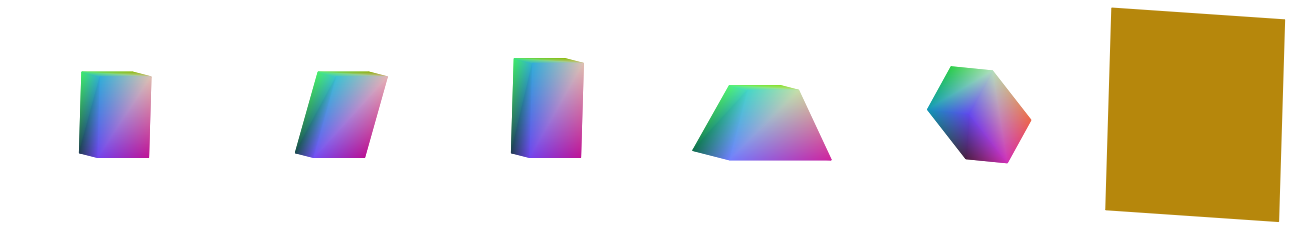

In [6]:
# figure size
SIZE = 3
mesh_scale = .25

scalar = 2.5
plane_cage = make_plane_cage(v_min=v_min*scalar, v_max=v_max*scalar)

v_list=[control_mesh.v, control_mesh_v2, control_mesh_v3, control_mesh_v4, control_mesh_v5, plane_cage.v]
f_list=[control_mesh.f, control_mesh.f, control_mesh.f, control_mesh.f, control_mesh.f, plane_cage.f]

# xyz Euler angle to rotate the mesh
rot_list=[ [5,20,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='normal')

In [7]:
src_mesh = EasyDict()
src_mesh.v, src_mesh.f = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
print('Loaded mesh')
print('\t src vertices:', src_mesh.v.shape, '\t faces:', src_mesh.f.shape) # (11248, 3) (22288, 3)


Loaded mesh
	 src vertices: (11248, 3) 	 faces: (22288, 3)


## slice coordinate space and visualize

(16384, 3)
(16384,)
(128, 128, 3)


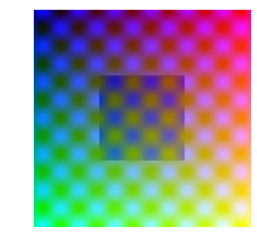

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


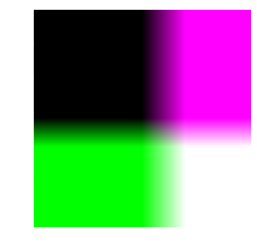

False True


In [8]:
X_v, Y_v, Z_v = plane_cage.v[:,0], plane_cage.v[:,1], plane_cage.v[:,2]

## sample points in space
HW = 128
X_coord, Y_coord = np.meshgrid(
    np.linspace(X_v.min(), X_v.max(), HW),
    np.linspace(Y_v.min(), Y_v.max(), HW),
)
XYZ_margin = np.stack([X_coord.ravel(), Y_coord.ravel(), X_coord.ravel()], axis=1)
# XYZ_margin = np.stack([Y_coord.ravel(), X_coord.ravel(), Y_coord.ravel()], axis=1)
print(XYZ_margin.shape)

# path = Path(plane_cage.v[:,:2]/scalar)
# inside = path.contains_points(XYZ_margin[:,[0,1]])
# inside_x_max = np.where(XYZ_margin[:,0] < v_max[0], True, False)
# inside_y_max = np.where(XYZ_margin[:,1] < v_max[1], True, False)
# inside_x_min = np.where(XYZ_margin[:,0] > v_min[0], True, False)
# inside_y_min = np.where(XYZ_margin[:,1] > v_min[1], True, False)
# inside =  inside_x_max & inside_x_min & inside_y_max & inside_y_min
inside = np.all((XYZ_margin[:, :2] > v_min[:2]) & (XYZ_margin[:, :2] < v_max[:2]), axis=1)
print(inside.shape)


## color for visualization
grid_intv=12
yy, xx = np.meshgrid(np.linspace(0,1,HW), np.linspace(0,1,HW), indexing='ij')

aa = np.tile(np.linspace(0,1,HW), HW)
bb = np.linspace(0,1,HW).repeat(HW)
pv = np.c_[aa, bb]

img = np.zeros((HW, HW, 3), dtype=np.float32)
img[...,0] = xx
img[...,1] = yy
img[...,2] = (np.sin(grid_intv*np.pi*xx)*np.cos(grid_intv*np.pi*yy)+1) * 0.5
img.reshape(-1,3)[inside,0] -= img.reshape(-1,3)[inside,2] *0.25
img.reshape(-1,3)[inside,1] -= img.reshape(-1,3)[inside,2] *0.25
img.reshape(-1,3)[inside,2] -= img.reshape(-1,3)[inside,2] *0.25
# img[...,0] -= img[...,2] *0.25
# img[...,1] -= img[...,2] *0.25
print(img.shape)

plt.imshow(img)
plt.show()
plt.imshow(XYZ_margin.reshape(HW,HW,-1))
plt.show()


def make_triangle(pv, margin=0.1):
    triangles = []
    index_map = {tuple(p): i for i, p in enumerate(pv)}

    for i, p in enumerate(pv):
        x, y = p
        right = (x + margin, y)
        up = (x, y + margin)
        diag = (x + margin, y + margin)
        
        if right in index_map and up in index_map and diag in index_map:
            a = i
            b = index_map[right]
            c = index_map[diag]
            d = index_map[up]
            
            triangles.append([a, b, c])
            triangles.append([a, c, d])

    triangles = np.array(triangles)
    return triangles

# ## triangulate grid
triangles = make_triangle(pv, aa[1])

# ## visualize
# triang = tri.Triangulation(pv[:, 0], pv[:, 1], triangles)

# plt.figure(figsize=(15,15))
# plt.triplot(triang, color='gray', linewidth=.01)
# plt.plot(pv[:, 0], pv[:, 1], '.')
# plt.gca().set_aspect('equal')
# plt.title("Triangles and Vertex Indices")
# plt.show()

print(inside.min(), inside.max())

## Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, hid_dim=64, is_w=False, pou=False):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, hid_dim)
        self.fc4 = nn.Linear(hid_dim, hid_dim)
        self.fc5 = nn.Linear(hid_dim, hid_dim)
        self.fc6 = nn.Linear(hid_dim, hid_dim)
        
        self.fc_out = nn.Linear(hid_dim, out_dim)
        self.act = nn.LeakyReLU(0.2)
        
        self.pou = pou
        self.is_w = is_w
        
        
    def forward(self, x_in):
        """
        Args:
            x_in (torch.tensor): (B,N,in_dim)
        Returns
            out: (B,N,out_dim)
        """
        out1 = self.act(self.fc1(x_in))
        out2 = self.act(self.fc2(out1))
        out3 = self.act(self.fc3(out2))
        out4 = self.act(self.fc4(out3))
        out5 = self.act(self.fc5(out4))
        out6 = self.act(self.fc6(out5))
        
        out = self.fc_out(out6)
        
        if self.is_w:
            # out = torch.nn.Sigmoid()(out) # cause boundary collapse at certain point !!!!! (kinda obvious)
            
            # out = torch.nn.Softplus()(out) # cause boundary collapse when used with POU
            # out = torch.nn.Softplus(beta=5)(out) # cause boundary collapse when used with POU
            # out = torch.nn.ReLU()(out)   # cause boundary collapse when used with POU            
            out = torch.nn.ELU(alpha=0.5)(out) # by giving up non-negativity, this works quite well
            # out = torch.nn.LeakyReLU(0.5)(out) # by giving up non-negativity, this works quite well
            
        if self.pou:
            ## cause boundary collapse when used with ReLU or Softplus
            out = out / (out.sum(dim=-1, keepdim=True)+1e-12) 
            
        return out

## train

In [30]:
adj_list = igl.adjacency_list(control_mesh.f)

i=0
dist_list = np.zeros(control_mesh.v.shape[0])
for adj in adj_list:
    dist = control_mesh.v[adj] - control_mesh.v[i][None]
    dist = np.linalg.norm(dist, axis=-1,keepdims=True)
    dist = dist.min(0) * 0.4
    dist_list[i] = dist
    i=i+1
    # break
dist_list = np.array(dist_list)
# dist_list

  0%|          | 0/20000 [00:00<?, ?it/s]

0 1.8550841808319092


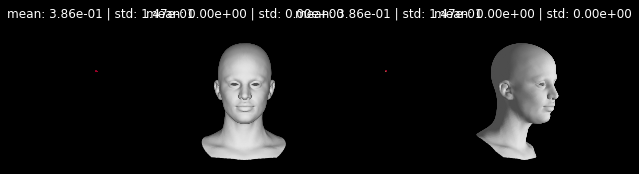

  5%|▌         | 1011/20000 [00:15<04:27, 70.97it/s]

1000 0.11764232069253922


 10%|█         | 2013/20000 [00:30<04:14, 70.64it/s]

2000 0.05404926836490631


 15%|█▌        | 3013/20000 [00:44<04:05, 69.14it/s]

3000 0.013048725202679634


 20%|██        | 4000/20000 [00:58<03:52, 68.95it/s]

4000 0.008648144081234932


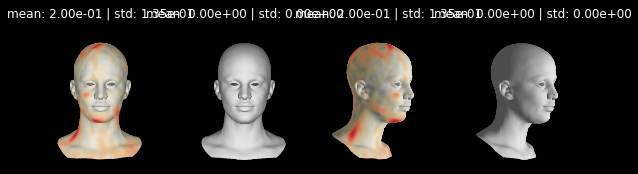

 25%|██▌       | 5013/20000 [01:14<03:36, 69.18it/s]

5000 0.009670615196228027


 30%|███       | 6006/20000 [01:28<03:41, 63.21it/s]

6000 0.008971698582172394


 35%|███▌      | 7009/20000 [01:43<03:13, 67.07it/s]

7000 0.00818249024450779


 40%|███▉      | 7995/20000 [01:57<02:49, 70.92it/s]

8000 0.007007033098489046


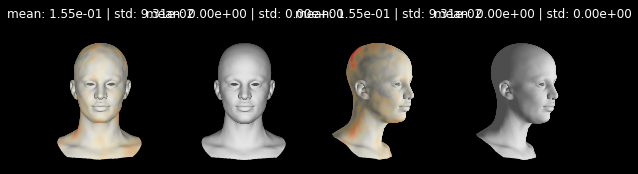

 45%|████▌     | 9009/20000 [02:12<02:31, 72.69it/s]

9000 0.007027251645922661


 50%|█████     | 10008/20000 [02:26<02:20, 70.91it/s]

10000 0.006180472671985626


 55%|█████▌    | 11006/20000 [02:40<02:06, 71.00it/s]

11000 0.007276223506778479


 60%|█████▉    | 11997/20000 [02:54<01:50, 72.69it/s]

12000 0.008201188407838345


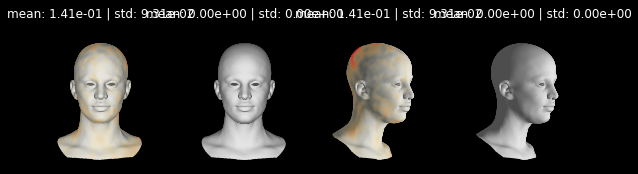

 65%|██████▌   | 13013/20000 [03:10<01:35, 72.81it/s]

13000 0.006131447851657867


 70%|███████   | 14008/20000 [03:24<01:29, 66.91it/s]

14000 0.007012466434389353


 75%|███████▌  | 15006/20000 [03:39<01:12, 69.34it/s]

15000 0.006517310626804829


 80%|███████▉  | 15997/20000 [03:53<00:56, 70.37it/s]

16000 0.005229438189417124


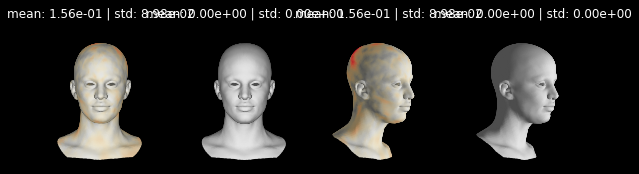

 85%|████████▌ | 17005/20000 [04:08<00:42, 70.79it/s]

17000 0.006991148926317692


 90%|█████████ | 18009/20000 [04:22<00:27, 71.31it/s]

18000 0.006529472768306732


 95%|█████████▌| 19013/20000 [04:36<00:13, 72.07it/s]

19000 0.0054205115884542465


100%|██████████| 20000/20000 [04:50<00:00, 68.84it/s]


In [68]:
set_seed(42)

device = 'cuda'

mesh_tgt = src_mesh.v
src_cage = control_mesh.v

mesh_tgt_th = torch.tensor(mesh_tgt)[None].float().to(device)
NV = mesh_tgt_th.shape[1]

src_cage_th = torch.tensor(src_cage).float().to(device)
cage_cntr_th = src_cage_th.mean(0)[None,None].to(device)

# deform_th = torch.tensor(control_mesh_v4).float().to(device)
# deform_th2 = torch.tensor(control_mesh_v5).float().to(device)

dist_list_th = torch.tensor(dist_list).float().to(device)


batch_size = 32
CC = src_cage_th.shape[0]
NC = src_cage_th.reshape(-1).shape[0]
NS = 1024
_sample = 128

POU_mesh = torch.ones(batch_size, NS).to(device)
POU_cage = torch.ones(batch_size, CC).to(device)
POU_grid = torch.ones(batch_size, _sample).to(device)

v_max_th = torch.tensor(v_max).float().to(device)
v_min_th = torch.tensor(v_min).float().to(device)

src_in = mesh_tgt_th.repeat(batch_size, 1, 1)
cage_in = src_cage_th[None].repeat(batch_size, 1, 1)
cage_eye = torch.eye(CC)[None].repeat(batch_size, 1, 1).to(device)


## Loss ------------------------------------------------------------
def non_negativity_loss(x_in):
    return torch.norm(torch.nn.ReLU()(x_in))

criterion=torch.nn.L1Loss()
# criterion=torch.nn.MSELoss()
##------------------------------------------------------------------


# model2 = MLP(in_dim=3, out_dim=src_cage.shape[0], pou=True, is_w=True).to(device) ## collapse
# model2 = MLP(in_dim=3, out_dim=src_cage.shape[0], pou=False, is_w=True).to(device)
model2 = MLP(in_dim=3, out_dim=src_cage.shape[0], pou=False, is_w=False).to(device)
# model2 = MLP(in_dim=3, out_dim=src_cage.shape[0], pou=True, is_w=False).to(device)
optimizer2 = torch.optim.Adam([*model2.parameters()], lr=2e-4)


model2.train()
LW = 1/4

USE_POU_LOSS = True
USE_NONNEGATIVE_LOSS = False ## quite strong..!!

EPS=1e-1

for i in tqdm(range(20_000)):
    optimizer2.zero_grad()
    
    loss=0    
    with torch.no_grad():
        randperm_idx = torch.randperm(NV)[:NS]
        src_in_randperm = src_in[:, randperm_idx]
    
    ## enforce linear precision for mesh vertex (not cage vertx)
    pred_mesh_W = model2(src_in_randperm)
    pred_mesh_tgt = pred_mesh_W @ src_cage_th
    loss += criterion(src_in_randperm, pred_mesh_tgt) * LW # linear precision
    
        
    ### ------------------------ lagrange property -----------------------    
    with torch.no_grad():
        asdasda = torch.rand((batch_size, CC, 3)).to(device) * 2 - 1
        deform_th = cage_in + asdasda * dist_list_th[None,:,None] *2 
    
    pred_cage_W = model2(cage_in)
        
    pred_cage_th = pred_cage_W @ cage_in
    pred_cage_th_deform = pred_cage_W @ deform_th
    
    # loss += criterion(cage_eye, pred_cage_W) #* LW  # somehow gives strange result
    
    loss += criterion(cage_in, pred_cage_th) * LW
    loss += criterion(deform_th, pred_cage_th_deform) * LW
    
    ### ------------------------------------------------------------------
    
    ### grid -------------------------------------------------------------    
    with torch.no_grad():
        ## random points from in and out grid # Monte Carlo sampling
        grid_in = cage_cntr_th + torch.randn((batch_size, _sample, 3)).to(device) * v_max_th * 2
        
        if USE_POU_LOSS:
            mesh_inside = torch.all((src_in_randperm >= v_min_th-EPS) & (v_max_th >= src_in_randperm+EPS), dim=-1)
            mesh_outside = ~mesh_inside
            
            grid_inside = torch.all((grid_in >= v_min_th-EPS) & (v_max_th >= grid_in+EPS), dim=-1)
            grid_outside = ~grid_inside
        
        #grid_in = torch.cat([grid_th_, src_cage_th.reshape(1,1,-1).repeat(1,_sample,1)], dim=-1).float()
        # grid_in = grid_th_.float()
    
    pred_grid_W = model2(grid_in)
    pred_grid_th = pred_grid_W @ src_cage_th
    
    loss += criterion(grid_in, pred_grid_th) * LW
    
    # ## non-negativity ----------------------------------------------------
    # ## - do not use with model.pou==True
    if USE_NONNEGATIVE_LOSS:
        loss += non_negativity_loss(-pred_mesh_W[mesh_inside]) * LW
        loss += non_negativity_loss(-pred_grid_W[grid_inside]) * LW
        ## make it positive outside
        # loss += torch.norm(torch.nn.ReLU()(-pred_mesh_W)) #* LW
        # loss += torch.norm(torch.nn.ReLU()(-pred_grid_W[grid_outside]))
    # ### ------------------------------------------------------------------
    
    ### partition of unity -----------------------------------------------
    ## - do not use with ReLU or softplus
    if USE_POU_LOSS:
        # loss += criterion(POU_cage, pred_cage_W.sum(-1)) * LW #* 0.1
        # with torch.no_grad():
        #     pred_mesh_W_normed_mask = pred_mesh_W[mesh_inside] / pred_mesh_W[mesh_inside].sum(-1,keepdims=True)
        #     pred_grid_W_normed_mask = pred_grid_W[grid_inside] / pred_grid_W[grid_inside].sum(-1,keepdims=True)
        # loss += criterion(pred_mesh_W_normed_mask.detach(), pred_mesh_W[mesh_inside]) * LW #* 0.1
        # loss += criterion(pred_grid_W_normed_mask.detach(), pred_grid_W[grid_inside]) * LW #* 0.1
        loss += criterion(POU_cage, pred_cage_W.sum(-1)) * LW #* 0.1
        loss += criterion(POU_mesh[mesh_inside], pred_mesh_W[mesh_inside].sum(-1)) * LW #* 0.1
        loss += criterion(POU_grid[grid_inside], pred_grid_W[grid_inside].sum(-1)) * LW #* 0.1
    ### ------------------------------------------------------------------
    
    
    loss.backward()
    optimizer2.step()
    if i % 1000==0:
        print(i, loss.item())
    if i % 4000==0:
        with torch.no_grad():
            pred_mesh_W_ = model2(mesh_tgt_th)
            pred_mesh_tgt_ = pred_mesh_W_ @ src_cage_th
            
            v_list=[ 
                pred_mesh_tgt_[0].detach().cpu().numpy(), mesh_tgt_th[0].detach().cpu().numpy(),
                pred_mesh_tgt_[0].detach().cpu().numpy(), mesh_tgt_th[0].detach().cpu().numpy()
            ]
            f_list=[ src_mesh.f, src_mesh.f, src_mesh.f, src_mesh.f ]
            # xyz Euler angle to rotate the mesh
            rot_list=[ [5,0,0], [5,0,0], [5,60,0], [5,60,0] ]
            plot_mesh_gouraud(v_list, f_list, mesh_scale=.5,
                    is_diff=True, diff_base=v_list[1], #diff_revert=True,
                    rot_list=rot_list, size=2, mode='shade')
        
torch.cuda.empty_cache()


In [ ]:
torch.cuda.empty_cache()

In [69]:
img_inside = img.copy()

model2.eval()

# src_in = torch.cat([
#     mesh_tgt_th,
#     src_cage_th.reshape(1,1,-1).repeat(1,NV,1)
# ], dim=-1)
# src_in_g = torch.cat([
#     torch.tensor(XYZ_margin[None]).float(),
#     src_cage_th.reshape(1,1,-1).repeat(1,XYZ_margin.shape[0],1)
# ], dim=-1)
src_in = mesh_tgt_th
src_in_g = torch.tensor(XYZ_margin[None]).float().to(device)

deform2 = control_mesh_v2
deform4 = control_mesh_v4
deform5 = control_mesh_v5

with torch.no_grad():
    pred_mesh2_W = model2(src_in).detach().cpu().numpy().squeeze()
    pred_grid2_W = model2(src_in_g).detach().cpu().numpy().squeeze()
    
    # mesh_inside_ = torch.all((src_in > v_min_th) & (src_in < v_max_th), dim=-1).detach().cpu().numpy().squeeze()
    # pred_mesh2_W[mesh_inside_] = pred_mesh2_W[mesh_inside_] / pred_mesh2_W[mesh_inside_].sum(-1,keepdims=True)
    
    # grid_inside_ = torch.all((src_in_g > v_min_th) & (src_in_g < v_max_th), dim=-1).detach().cpu().numpy().squeeze()
    # pred_grid2_W[grid_inside_] = pred_grid2_W[grid_inside_] / pred_grid2_W[grid_inside_].sum(-1,keepdims=True)
    
    pred_mesh2_src = pred_mesh2_W @ src_cage
    pred_mesh2_def2 = pred_mesh2_W @ deform2
    pred_mesh2_def4 = pred_mesh2_W @ deform4
    pred_mesh2_def5 = pred_mesh2_W @ deform5
    
    pred_grid2_src = pred_grid2_W @ src_cage
    pred_grid2_def2 = pred_grid2_W @ deform2
    pred_grid2_def4 = pred_grid2_W @ deform4
    pred_grid2_def5 = pred_grid2_W @ deform5
    
pred_cage_W_np = pred_cage_W.detach().cpu().numpy()
print(pred_cage_W_np[0].shape, pred_cage_W_np[0].sum(1).sum(), f' \t min: {pred_cage_W_np[0].min():.5e} max: {pred_cage_W_np[0].max():.5e}')
print(pred_mesh2_W.shape, pred_mesh2_W.sum(1).sum(), f'min: {pred_mesh2_W.min():.5e} max: {pred_mesh2_W.max():.5e}')
print(pred_grid2_W.shape, pred_grid2_W.sum(1).sum(), f'min: {pred_grid2_W.min():.5e} max: {pred_grid2_W.max():.5e}')
pred_mesh2_W.sum(0).shape

(8, 8) 8.010404  	 min: -1.00642e-03 max: 1.00161e+00
(11248, 8) 11239.503 min: -1.08960e-01 max: 9.60095e-01
(16384, 8) 16902.41 min: -4.42140e-01 max: 2.48862e+00


(8,)

C = cage
|       GT       | recon w/ init C |    init C    | deformed mesh 1 |  deformed C 1 | deformed mesh 2 | deformed C 2  | deformed mesh 3 | deformed C 3


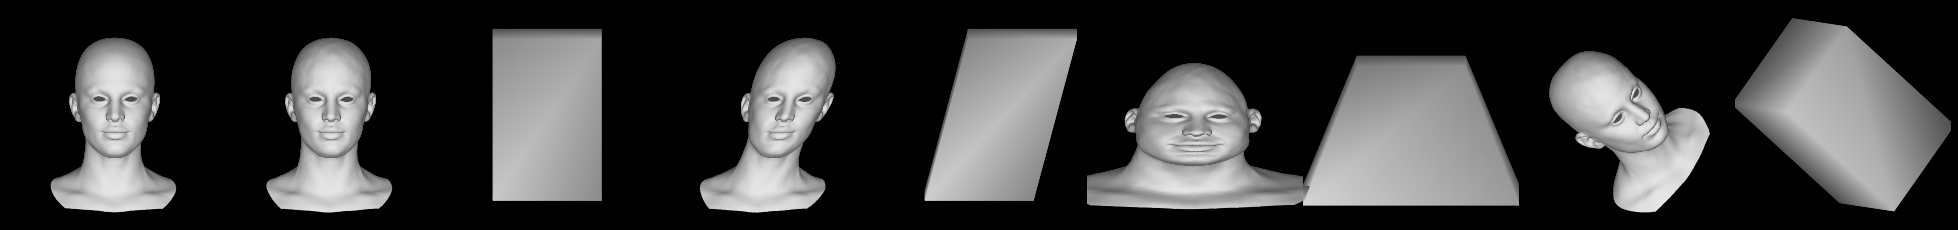

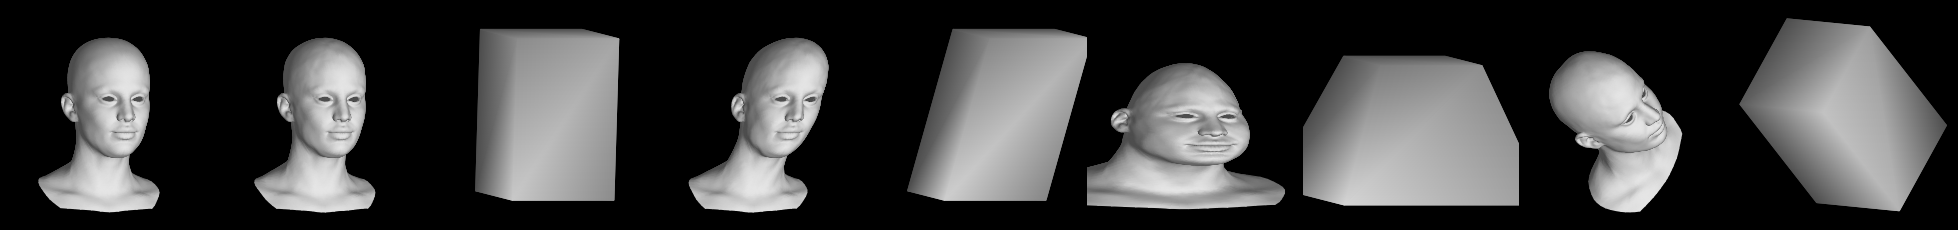

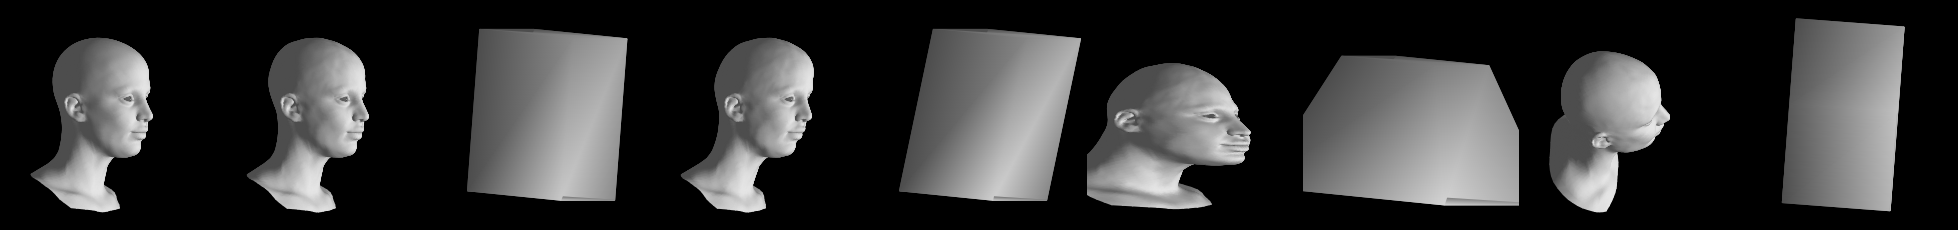

In [70]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .5

# v_list=[ pred_mesh2_src, control_mesh.v, control_mesh_v2, control_mesh_v4, XYZ_margin]
# v_list=[ pred_mesh2_def2, control_mesh.v, control_mesh_v2, control_mesh_v4, XYZ_margin]
# v_list=[ pred_mesh2_def4, control_mesh.v, control_mesh_v2, control_mesh_v4]
# f_list=[ src_mesh.f, control_mesh.f, control_mesh.f, control_mesh.f]
v_list=[ mesh_tgt, pred_mesh2_src, control_mesh.v, pred_mesh2_def2, control_mesh_v2, pred_mesh2_def4, control_mesh_v4, pred_mesh2_def5, control_mesh_v5]
f_list=[ src_mesh.f, src_mesh.f, control_mesh.f, src_mesh.f, control_mesh.f, src_mesh.f, control_mesh.f, src_mesh.f, control_mesh.f]

print('C = cage')
print('|       GT       | recon w/ init C |    init C    | deformed mesh 1 |  deformed C 1 | deformed mesh 2 | deformed C 2  | deformed mesh 3 | deformed C 3')
# xyz Euler angle to rotate the mesh
rot_list=[ [5,0,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

rot_list=[ [5,20,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

rot_list=[ [5,60,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')


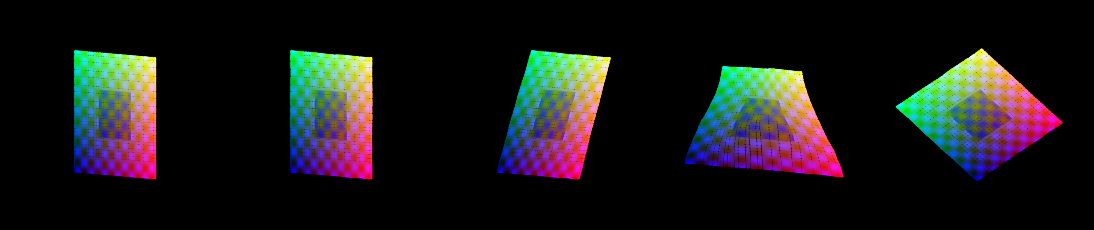

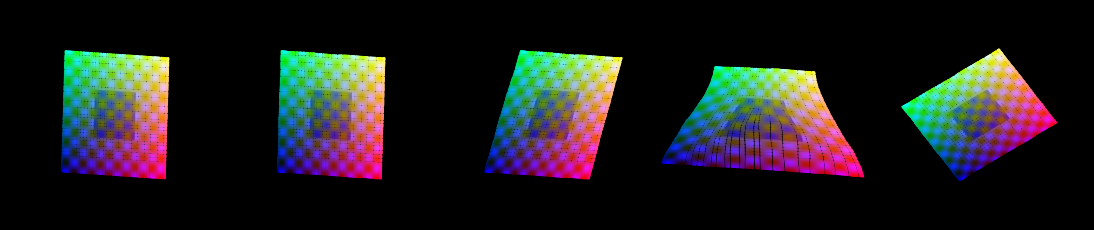

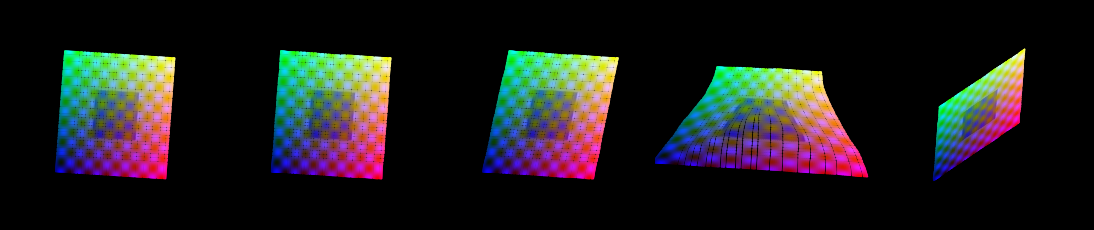

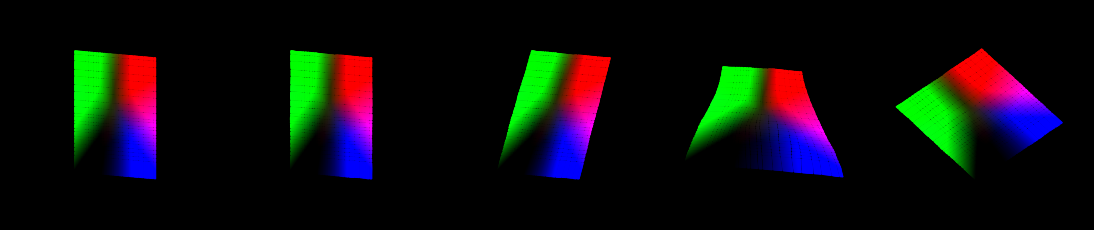

In [71]:

SIZE = 3
mesh_scale = .15

v_list=[ XYZ_margin, pred_grid2_src, pred_grid2_def2, pred_grid2_def4, pred_grid2_def5]
f_list=[ triangles, triangles, triangles, triangles, triangles]
c_list=[ img.reshape(-1,3), img.reshape(-1,3), img.reshape(-1,3), img.reshape(-1,3), img.reshape(-1,3)]
# c_list=[ pred_grid2_W[:,[0,3,4]]]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [5,0,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, c_list, is_color=True,
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

rot_list=[ [5,20,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, c_list, is_color=True,
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

rot_list=[ [5,60,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, c_list, is_color=True,
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

c_list2=[ pred_grid2_W[:,[0,3,4]]]*len(v_list)
rot_list=[ [5,0,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, c_list2, is_color=True,
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')